In [52]:
## Trim down imports to only neccesary 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from sklearn.preprocessing import StandardScaler

import datasets_1 as datasets

import os
import re
from sklearn.model_selection import GridSearchCV

import itertools
import torch.optim as optim

from datetime import date
from torch.optim.lr_scheduler import StepLR


In [7]:
svid_t = datasets.load_SVID_temperature()
svid_o = datasets.load_SVID_other(keep_all=True)
svid_b = datasets.load_SVID_brGDGTs()


DATA_DIR = "../data/"
with open(os.path.join(DATA_DIR, "SVID_brGDGTs.csv"), "r") as inf:
        df = pd.read_csv(inf)
        
lvid_o = pd.read_excel('../data/LVID_bulk_geochem.xlsx')
lvid_o.head()

lvid_o.columns = lvid_o.columns.str.strip()

lvid_o.head()

# Function to clean column names
def clean_column_name(column_name):
    # Remove text within parentheses
    column_name = re.sub(r' \([^)]*\)', '', column_name)
    # Replace spaces with underscores
    column_name = column_name.replace(' ', '_')
    
    # Convert to lower case
    return column_name.lower().strip()

svid_o.head()

# Apply the function to each column name
lvid_o.columns = [clean_column_name(col) for col in lvid_o.columns]

,Sample ID,Section depth (cm),Cum depth (cm),Age (BP),δ13CVPDB (‰),Total C (µg),%TOC,δ15NAir (‰),Total N (µg),%N,C/N,Sample Weight (mg) from Sample List,Sample mass (ug)
0,20LVID-02A-19,19.0,3.0,-4,-26.801533,1374.888037,7.014735,0.232224,131.049083,0.668618,10.491398,19.6,19600
1,20LVID-02A-22 5,22.5,6.5,58,-24.681210,1464.275417,7.213179,0.196497,135.527495,0.667623,10.804268,20.3,20300
2,20LVID-02A-26,26.0,10.0,127,-24.237128,1101.039173,4.186461,0.947665,100.056127,0.380442,11.004215,26.3,26300
3,20LVID-02A-29 5,29.5,13.0,201,-24.981566,1240.047631,2.966621,1.093422,108.097362,0.258606,11.471581,41.8,41800
4,20LVID-02A-33,33.0,17.0,287,-24.953268,1372.130105,4.848516,0.807939,120.690241,0.426467,11.369023,28.3,28300


,Sample ID,Section depth (cm),Cum depth (cm),Age (BP),δ13CVPDB (‰),Total C (µg),%TOC,δ15NAir (‰),Total N (µg),%N,C/N,Sample Weight (mg) from Sample List,Sample mass (ug)
0,20LVID-02A-19,19.0,3.0,-4,-26.801533,1374.888037,7.014735,0.232224,131.049083,0.668618,10.491398,19.6,19600
1,20LVID-02A-22 5,22.5,6.5,58,-24.681210,1464.275417,7.213179,0.196497,135.527495,0.667623,10.804268,20.3,20300
2,20LVID-02A-26,26.0,10.0,127,-24.237128,1101.039173,4.186461,0.947665,100.056127,0.380442,11.004215,26.3,26300
3,20LVID-02A-29 5,29.5,13.0,201,-24.981566,1240.047631,2.966621,1.093422,108.097362,0.258606,11.471581,41.8,41800
4,20LVID-02A-33,33.0,17.0,287,-24.953268,1372.130105,4.848516,0.807939,120.690241,0.426467,11.369023,28.3,28300


,Sediment_Depth,Age,%TOC,d13C,d15N,%TN,C/N,BSi,year
0,0.0,11.6732,3.6,-25.9,0.7,0.4,8.0,76.672,2020.0000
1,3.0,52.5294,3.1,-25.8,0.7,0.4,8.5,59.449,1979.1438
2,7.0,99.2222,2.9,-25.7,0.6,0.3,9.4,64.895,1932.4510
3,11.0,145.9150,3.1,-25.9,0.3,0.3,9.4,54.073,1885.7582
4,15.0,192.6078,3.1,-25.9,0.7,0.3,9.3,57.037,1839.0654


In [4]:
class ImageData:
    def __init__(self, name, image):
        self.name = name
        self.image = image
        self.start = None
        self.end = None

ILLUME-SVID20-1B-7B-1-A.jpg 1B-7B-1-A


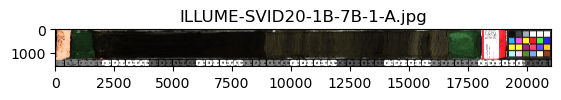

ILLUME-SVID20-1B-6B-1-A.jpg 1B-6B-1-A


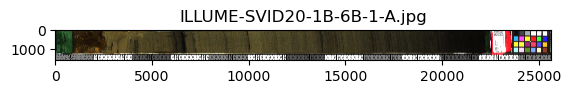

ILLUME-SVID20-1B-2B-1-A_complete.jpg 1B-2B-1-A


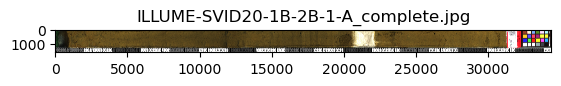

ILLUME-SVID20-1B-3B-1-A_complete.jpg 1B-3B-1-A


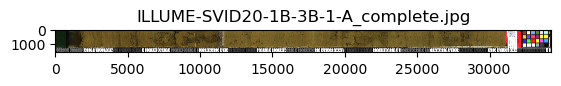

ILLUME-SVID20-1B-5B-1-A_complete.jpg 1B-5B-1-A


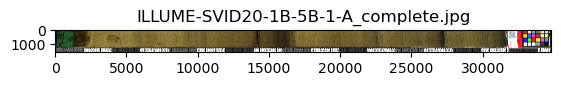

ILLUME-SVID20-1B-4B-1-A_complete.jpg 1B-4B-1-A


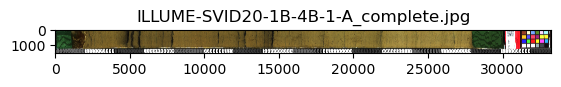

ILLUME-SVID20-1B-1B-1-A_complete.jpg 1B-1B-1-A


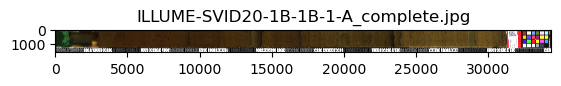

4ILLUME-LVID20-1B-4B-1-A.jpg 4


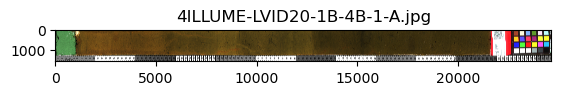

2ILLUME-LVID20-1B-2B-1-A.jpg 2


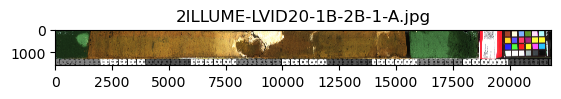

1ILLUME-LVID20-1B-1B-1-A.jpg 1


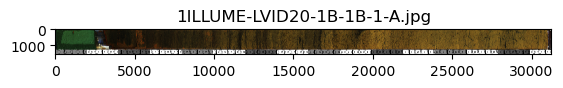

6ILLUME-LVID20-1A-5B-1-A.jpg 6


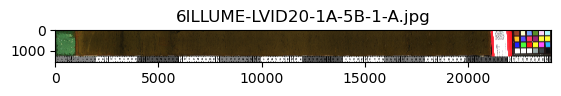

8ILLUME-LVID20-1A-7B-1-A.jpg 8


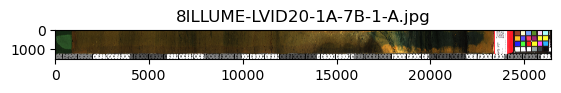

3ILLUME-LVID20-1B-3B-1-A.jpg 3


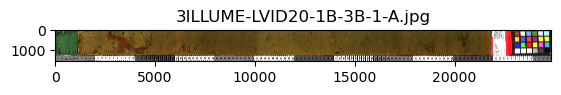

5ILLUME-LVID20-1A-4B-1-A.jpg 5


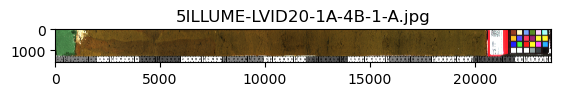

7ILLUME-LVID20-1A-6B-1-A.jpg 7


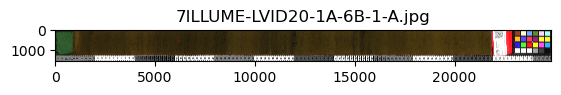

9ILLUME-LVID20-1A-8B-1-A.jpg 9


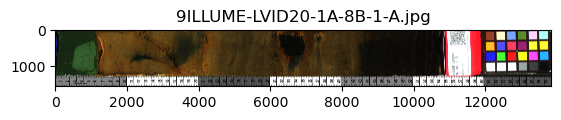

In [132]:
full_SVID = []

full_LVID = []


def sortimg(img):
    return img.name

def load_and_display_images(folder_path, img_store, lake):
    # List all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        # Construct full file path
        file_path = os.path.join(folder_path, file)
        if lake == "SVID":
            obj_name = file[14:23]
        elif lake == "LVID":
            obj_name = file[0]
        else:
            return "New Lake. Re-verify naming"
        #print(file, obj_name)

        # Check if the file is an image (you can add more extensions if needed)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image
            img = mpimg.imread(file_path)

            new_img = ImageData(name=obj_name, image=img)
            
            # Display the image
            #plt.imshow(img)
            #plt.title(file)
            #plt.show()
            
            img_store.append(new_img)

# Replace 'your_folder_path' with the path to the folder containing your images

load_and_display_images('img_data/SVID',full_SVID, "SVID")
## reverse = False because 1B-7B seems darkest so would make sense for it to be on the bottom
full_SVID.sort(key=sortimg,reverse=False)

load_and_display_images('img_data/LVID',full_LVID, "LVID")
## reverse = False because 1B-7B seems darkest so would make sense for it to be on the bottom
full_LVID.sort(key=sortimg,reverse=False)

In [76]:
def crop_image(image_data, box, display = False):
    # Unpack the box coordinates
    left, lower, right, upper = box

    # Crop the image using array slicing
    cropped_image = image_data.image[lower:upper, left:right]

    # Update image data
    cropped = cropped_image

    # Optionally, display the cropped image
    if display:
        plt.imshow(cropped)
        plt.axis('off')  # This hides the axis
        plt.show()

    return cropped


cropped_LVID = []
cropped_SVID = []

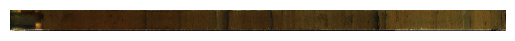

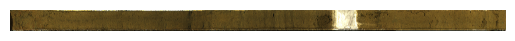

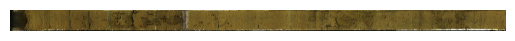

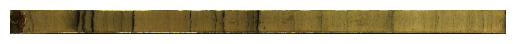

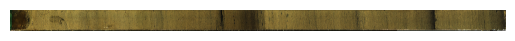

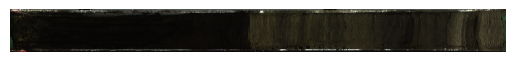

In [133]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 1. 1000 0 31275 1300
    ## 6-157 cm
box = (1000, 0, 31275, 1300)

full_SVID[0].start = 1000
full_SVID[0].end = 31275

cropped_image = crop_image(full_SVID[0], box)
cropped_SVID.append(ImageData(full_SVID[0].name,cropped_image))




## This is only guessing, do something better potentially. More fine grain
## 2. 800 0 31290 1300
    ## 5-157 cm
box = (800, 0, 31290, 1300)

full_SVID[1].start = 800
full_SVID[1].end = 31290

cropped_image = crop_image(full_SVID[1], box)
cropped_SVID.append(ImageData(full_SVID[1].name,cropped_image))


## This is only guessing, do something better potentially. More fine grain
## 3. 800 0 31100 1300
    ## 5-156 cm
box = (800, 0, 31100, 1300)

full_SVID[2].start = 800
full_SVID[2].end = 31100

cropped_image = crop_image(full_SVID[2], box)
cropped_SVID.append(ImageData(full_SVID[2].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 4. 1200 0 28000 1300
    ## 7-140.5 cm
box = (1200, 0, 28000, 1300)

full_SVID[3].start = 1200
full_SVID[3].end = 28000

cropped_image = crop_image(full_SVID[3], box)
cropped_SVID.append(ImageData(full_SVID[3].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 5. 1200 0 31700 1300
    ## 7-159 cm
box = (1200, 0, 31700, 1300)

full_SVID[4].start = 1200
full_SVID[4].end = 31700

cropped_image = crop_image(full_SVID[4], box)
cropped_SVID.append(ImageData(full_SVID[4].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 6. 875 0 22325 1300
    ## 5.5-112 cm
box = (875, 0, 22325, 1300)

full_SVID[5].start = 875
full_SVID[5].end = 22325

cropped_SVID.append(ImageData(full_SVID[5].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 7. 1600 0 16750 1300
    ## 9-84 cm
box = (1600, 0, 16750, 1300)

full_SVID[6].start = 1600
full_SVID[6].end = 16750

cropped_image = crop_image(full_SVID[6], box)
cropped_SVID.append(ImageData(full_SVID[6].name,cropped_image))


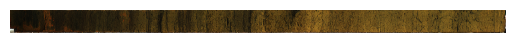

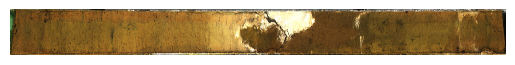

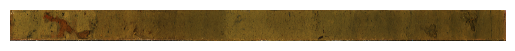

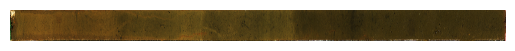

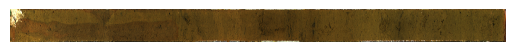

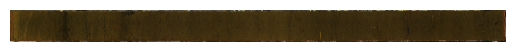

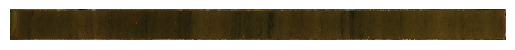

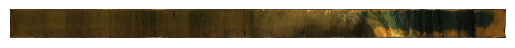

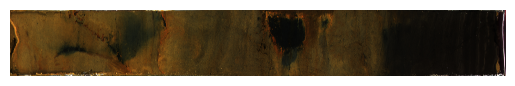

In [134]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 1. 3200 0 31075 1300
    ## 17-156 cm
    

start = 3200
end = 31075
box = (start, 0, end, 1300)

full_LVID[0].start = start
full_LVID[0].end = end

cropped_image = crop_image(full_LVID[0], box)
cropped_LVID.append(ImageData(full_LVID[0].name,cropped_image))


## This is only guessing, do something better potentially. More fine grain
## 2. 1400 0 15525 1300
    ## 8-78 cm 
start = 1400
end = 15525
box = (start, 0, end, 1300)
full_LVID[1].start = start
full_LVID[1].end = end

cropped_image = crop_image(full_LVID[1], box)
cropped_LVID.append(ImageData(full_LVID[1].name,cropped_image))


## This is only guessing, do something better potentially. More fine grain
## 3. 1200 0 21850 1300
    ## 7-109.5 cm
start = 1200
end = 21850
box = (start, 0, end, 1300)

full_LVID[2].start = start
full_LVID[2].end = end

cropped_image = crop_image(full_LVID[2], box)
cropped_LVID.append(ImageData(full_LVID[2].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 4. 1000 0 21650 1300
    ## 6-108.5 cm
start = 1000
end = 21650
box = (start, 0, end, 1300)

full_LVID[3].start = start
full_LVID[3].end = end

cropped_image = crop_image(full_LVID[3], box)
cropped_LVID.append(ImageData(full_LVID[3].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 5. 1000 0 20600 1300
    ## 6-103.5 cm
start = 1000
end = 20600
box = (start, 0, end, 1300)

full_LVID[4].start = start
full_LVID[4].end = end

cropped_image = crop_image(full_LVID[4], box)
cropped_LVID.append(ImageData(full_LVID[4].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 6. 1000 0 21150 1300
    ## 6-106 cm
start = 1000
end = 21150
box = (start, 0, end, 1300)

full_LVID[5].start = start
full_LVID[5].end = end

cropped_image = crop_image(full_LVID[5], box)
cropped_LVID.append(ImageData(full_LVID[5].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 7. 900 0 21900 1300
    ## 5.5-110 cm
start = 900
end = 21900
box = (start, 0, end, 1300)

full_LVID[6].start = start
full_LVID[6].end = end

cropped_image = crop_image(full_LVID[6], box)
cropped_LVID.append(ImageData(full_LVID[6].name,cropped_image))

## 8. 900 0 23400 1300
    ## 5.5-117.5 cm
start = 900
end = 23400
box = (start, 0, end, 1300)

full_LVID[7].start = start
full_LVID[7].end = end

cropped_image = crop_image(full_LVID[7], box)
cropped_LVID.append(ImageData(full_LVID[7].name,cropped_image))

## 9. 1200 0 10900 1300
    ## 7-54.5 cm

start = 1200
end = 10900
box = (start, 0, end, 1300)

full_LVID[8].start = start
full_LVID[8].end = end

cropped_image = crop_image(full_LVID[8], box)
cropped_LVID.append(ImageData(full_LVID[8].name,cropped_image))




In [135]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values
        self.labels = labels

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        image = self.pixel_values[idx]
        label = self.labels[idx]
        return image, label

In [136]:
def attach_labels(target,sample_df, images, depth_col, scaled=False):
    if scaled:
        target_col = target + '_scaled'
    else:
        target_col = target
        



    full_depth = 0
    chunk_size = 997
    chunks = []
    chunk_labels = []

    ## Pixels to cm
        ## To make sure our depths are accurate
    p_to_cm = 5/997

    scaler = None
    if scaled:
        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler to the target column and transform it
        sample_df[target_col] = scaler.fit_transform(sample_df[[target]])



    j = 0
    for i,object in enumerate(images):
        full_end = object.end
        start_pixel = object.start
        end_pixel = object.start + chunk_size
        while end_pixel <= full_end:
            box = (start_pixel, 0, end_pixel, 1300)

            ## Adding on labels
            section_data =  sample_df[( sample_df[depth_col] >= full_depth) & 
                            ( sample_df[depth_col] < (full_depth+5))]

            # Calculate the average target value for the segment
            average_target = section_data[target_col].mean()
            if len(section_data) > 0:
                chunk_labels.append(average_target)
                chunk = object.image[0:1300, start_pixel:end_pixel]

                chunks.append(chunk) 


            ## While loop Increments
            start_pixel += chunk_size
            end_pixel += chunk_size
            j += 1
            if end_pixel > full_end:
                full_depth += (full_end - (end_pixel - chunk_size)) * p_to_cm
            else:
                full_depth += 5
                
     # Convert your lists to numpy arrays
    images_array = np.array(chunks)
    labels_array = np.array(chunk_labels)

    # Assuming NaN is represented as np.nan in labels_array
    # Create boolean masks
    nan_mask = np.isnan(labels_array)
    non_nan_mask = ~nan_mask

    # Filter the arrays
    images_test = images_array[nan_mask]
    images_known = images_array[non_nan_mask]
    labels_test = labels_array[nan_mask]
    labels_known = labels_array[non_nan_mask]


    feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-patch16-224')
    inputs = feature_extractor(images=images_known, return_tensors="pt")
    
        # Assuming your pixel_values are already a tensor in the shape [num_images, channels, height, width]
    # and labels is a list or a 1-D tensor of label values:
    pixel_values_tensor = inputs['pixel_values'] 
    labels_tensor = torch.tensor(labels_known, dtype=torch.float32)
    
    return pixel_values_tensor, labels_tensor, inputs, scaler
                
        
def create_dataset(images, labels, scaled=True):
    
    ## could scale here ##
    scaler = None
    if scaled:
         # Ensure labels are a numpy array
        labels = np.array(labels)

        # Reshape labels to 2D for scaling
        labels_2d = labels.reshape(-1, 1)

        # Initialize and fit the StandardScaler
        scaler = StandardScaler()
        scaled_labels = scaler.fit_transform(labels_2d)

        # Reshape the scaled labels back to 1D
        labels = scaled_labels.flatten()
        
    # Create the custom dataset
    dataset = CustomDataset(images, labels)

    # Split the dataset into training and validation sets
    train_indices, val_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42)

    # Subset for train and validation=
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Create a dataloader for both the training and validation sets
        ## 5 seems like a fine batch size
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

    return train_loader, val_loader, scaler

In [137]:
target= "%TOC"
pixel_values_tensor, temp_labels, inputs, _ = attach_labels(target, svid_o, full_SVID, 'Sediment_Depth')
target= "%toc"
pixel_values_tensor2, temp_labels2, inputs2, _  = attach_labels(target, lvid_o, full_LVID, 'cum_depth')

img_tensor = torch.cat((pixel_values_tensor,pixel_values_tensor2))
labels_tensor = torch.cat((temp_labels,temp_labels2))

train_loader, val_loader, scaler = create_dataset(img_tensor, labels_tensor)

/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [138]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x
    

def calculate_rmse_and_r2(loader, model, scaler, scaled = True):
    ## Should probably make device a param for consistency
    device = torch.device("cuda:0")
    model.eval()
    targets, predictions = [], []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            embeddings = custom_model(images.to("cpu"))  # Get embeddings from the ViT
            preds = model(embeddings.to(device))  # Pass embeddings to the CNN
            predictions.extend(preds.view(-1).tolist())
            targets.extend(labels.tolist())

    # Convert to tensors
    predictions = torch.tensor(predictions).to(device)
    targets = torch.tensor(targets).to(device)

    if scaled:
        # Move targets to CPU for scaling, as scaler works on CPU
        targets_scaled = scaler.transform(targets.cpu().numpy().reshape(-1, 1)).flatten()
        targets_scaled = torch.tensor(targets_scaled).to(device)  # Move back to GPU

        # Calculate RMSE on scaled targets
        rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets_scaled))

        # Calculate R^2 on scaled targets (requires CPU operation)
        r2_value = r2_score(targets_scaled.cpu(), predictions.cpu())
    else:
        # Calculate RMSE on unscaled targets
        rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets))

        # Calculate R^2 on unscaled targets (requires CPU operation)
        r2_value = r2_score(targets.cpu(), predictions.cpu())

    return rmse_value.item(), r2_value


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f"Using device for VIT: {device}")
# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224') # .to(device)

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False
    

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit) #.to(device)

embeddings = custom_model(inputs['pixel_values']) 

print(embeddings[0].shape)

torch.Size([192, 14, 14])


In [140]:
## Preventing model arch from printing everytime
InteractiveShell.ast_node_interactivity = "last_expr"
warnings.filterwarnings('ignore')

In [141]:
## Grid Search
    ## Second grid search

class GridRegressionCNN(nn.Module):
    def __init__(self, embedding_dim, layer_sizes, use_dropout=True, use_batch_norm=True, act_func=nn.ReLU()):
        super(GridRegressionCNN, self).__init__()
        
        layers = []
        in_channels = embedding_dim

        for size in layer_sizes:
            layers.append(nn.Conv2d(in_channels, size, kernel_size=3, padding=1))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(size))
            
            layers.append(act_func)

            if use_dropout:
                ## Changed to 0.1 on 12/19
                layers.append(nn.Dropout(p=0.1))

            in_channels = size

        layers.append(nn.AdaptiveAvgPool2d((1, 1)))

        ## convert list into sequential
        self.layers = nn.Sequential(*layers)

        self.fc = nn.Linear(in_features=layer_sizes[-1], out_features=1)

    def forward(self, x):
        x = self.layers(x)

        ## flattening tensor for fully connected
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        return x
    


In [2]:
# Define the hyperparameter grid

# Function to train and evaluate the model
def train_evaluate_model(params,train_loader,val_loader,scaler, full_labels, scaled = False):
    
    ## Maybe have there be a check for whether were using a gpu?
    
    device = torch.device("cuda:0")
    print(f"Using device in train_evaluate: {device}")
    
    
    model = GridRegressionCNN(embedding_dim=192, layer_sizes=params['layer_sizes'], use_dropout=params['use_dropout'], use_batch_norm=params['use_batch_norm'],act_func = params['activations']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    loss_function = nn.MSELoss()

    # Define LR scheduler
    if params['use_lr_decay']:
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # Adjust these parameters as needed
    
    # Reset metrics for each training session
    train_losses = []
    train_rmses = []
    val_rmses = []
    
    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0
        #print(f'epoch {epoch} of {epochs}')
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch[0].to(device), batch[1].to(device)
            embeddings = custom_model(images.to("cpu"))  # Get embeddings from the ViT
            predictions = model(embeddings.to(device))  # Pass embeddings to the CNN
            loss = loss_function(predictions.squeeze(), labels) 
            loss.backward()
            optimizer.step()
            if params['use_lr_decay']:
                scheduler.step()  # Update the learning rate
            train_loss += loss.item()

        # Append average loss and RMSE for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_rmse, _ = calculate_rmse_and_r2(train_loader, model, scaler, scaled)
        val_rmse, _ = calculate_rmse_and_r2(val_loader, model, scaler, scaled)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    
    ## Changed range_target to mean -- 01/07/24
    range_target = torch.mean(full_labels)
    if scaled:
        normal_rmse = scaler.inverse_transform([[val_rmses[-1]]])[0, 0]
        rmse_perc = (normal_rmse / range_target.item()) * 100
    else:
        rmse_perc = (val_rmses[-1] / range_target.item()) * 100
    print(f'PERFORMANCE: \n params: {params}, \n val_rmse: {val_rmses[-1]} \n rmse_perc: {rmse_perc} \n')

    return {'train_rmse': train_rmses[-1], 'val_rmse': val_rmses[-1], 'rmse_perc': rmse_perc}

def manual_grid_search(lake,target,param_grid, train_loader, val_loader,scaler, labels, scaled = False):
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    results = []
    for i, params in enumerate(all_params):
        epochs = params['epochs']
        print(f'run {i+1} of {len(all_params)}')
        performance = train_evaluate_model(params, train_loader, val_loader,scaler, labels, scaled)
        results.append({'params': params, 'performance': performance})

    # Convert results to a DataFrame for easier handling
    results_df = pd.DataFrame([{
        'epochs': r['params']['epochs'],
        'learning_rate': r['params']['learning_rate'],
        'layer_sizes': r['params']['layer_sizes'],
        'use_dropout': r['params']['use_dropout'],
        'use_batch_norm': r['params']['use_batch_norm'],
        'use_lr_decay': r['params']['use_lr_decay'],
        'activation': r['params']['activations'],
        'train_rmse': r['performance']['train_rmse'],
        'val_rmse': r['performance']['val_rmse'],
        'RMSE %': r['performance']['rmse_perc']
    } for r in results])

    # Save the results to a CSV file
    target = target.replace("/", "-")
    title = "grid_results/" + lake + "/" + target + "_" + date.today().strftime("%d%m%Y_%H%M%S") + '_grid_search_results.csv'
    print(f'saved to {title}')
    results_df.to_csv(title, index=False)

In [143]:
## Warnings off
## Preventing model arch from printing everytime
InteractiveShell.ast_node_interactivity = "last_expr"
warnings.filterwarnings('ignore')

#['sample_id', 'section_depth', 'cum_depth', 'age', 'δ13cvpdb', 'total_c',
        #'%toc', 'δ15nair', 'total_n', '%n', 'c/n',
       #'sample_weight_from_sample_list', 'sample_mass'] MBT
        
        ## lvid_o or df
## Create Training set for each in for loop

## have a way to turn off scaling?
## TOC not included for now, did it manually before

# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'layer_sizes': [[256, 128, 64], [128, 64, 32], [128, 128, 128],[128, 64], [256,64],[512,128,64]],
#     'use_dropout': [True, False],
#     'use_batch_norm': [True, False],
#     'activations': [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()]
# }

param_grid = {
    'learning_rate': [0.00000001, 0.0000005, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001],
    'layer_sizes': [[256,64], [128,64], [256,128,64], [512,256,64], [512,256,128,64]],
    'use_dropout': [True],
    'use_batch_norm': [True],
    'use_lr_decay': [True,False],
    'activations': [nn.Sigmoid()],
    'epochs': [100,200,500]
}

targets = ['%TOC']
lake = 'VIDs'
for target in targets:
    print(f'BEGIN {target}\n')
    data_df = svid_o
    if target == "MBT":
        print("not_implemented")
        break
        #data_df = df
        #train_loader,val_loader,scaler, _ = create_dataset(target,data_df, full_SVID)
    else:
        target= "%TOC"
        pixel_values_tensor, temp_labels, inputs, _ = attach_labels(target, svid_o, full_SVID, 'Sediment_Depth')
        target= "%toc"
        pixel_values_tensor2, temp_labels2, inputs2, _  = attach_labels(target, lvid_o, full_LVID, 'cum_depth')

        img_tensor = torch.cat((pixel_values_tensor,pixel_values_tensor2))
        labels_tensor = torch.cat((temp_labels,temp_labels2))

        train_loader, val_loader, scaler = create_dataset(img_tensor, labels_tensor, scaled =False )
    
        
    ## Do grid search in function
    manual_grid_search(lake, target, param_grid, train_loader, val_loader,scaler, labels_tensor, scaled = False)
    print(f'FINISHED {target}\n')


BEGIN %TOC

run 1 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 4.544682025909424 
 rmse_perc: 103.37398346647775 

run 2 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 4.416134834289551 
 rmse_perc: 92.3444208453189 

run 3 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 4.390063285827637 
 rmse_perc: 54.808918323631005 

run 4 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 

PERFORMANCE: 
 params: {'learning_rate': 1e-07, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 4.554854393005371 
 rmse_perc: 103.17390642197277 

run 33 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-07, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 5.009462833404541 
 rmse_perc: 115.06579621109772 

run 34 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-07, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 4.432562828063965 
 rmse_perc: 127.76204304741847 

run 35 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-07, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 4.813326358795166 


PERFORMANCE: 
 params: {'learning_rate': 1e-05, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 2.4715418815612793 
 rmse_perc: 45.552044002481495 

run 64 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-05, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 3.6581199169158936 
 rmse_perc: 68.98413756626508 

run 65 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-05, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 2.8721354007720947 
 rmse_perc: 39.696472115676116 

run 66 of 106
PERFORMANCE: 
 params: {'learning_rate': 1e-05, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 2.109354019165039

PERFORMANCE: 
 params: {'learning_rate': 0.001, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 1.5142803192138672 
 rmse_perc: 42.39647849040321 

run 95 of 106
PERFORMANCE: 
 params: {'learning_rate': 0.001, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 1.3756201267242432 
 rmse_perc: 171.95252608969963 

run 96 of 106
PERFORMANCE: 
 params: {'learning_rate': 0.001, 'layer_sizes': [128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 1.3991769552230835 
 rmse_perc: 22.82686210173002 

run 97 of 106
PERFORMANCE: 
 params: {'learning_rate': 0.001, 'layer_sizes': [256, 128, 64], 'use_dropout': True, 'use_batch_norm': True, 'use_lr_decay': False, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 1.428523063659